# Comparison between 2$\kappa$ and 2$T$ models

In [89]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
import mpmath as mp
%config InlineBackend.figure_format = 'svg'

In [90]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [91]:
def fkM(v):
    r_s = ( 1 + (v-u_s)**2/kappa_s/v_s**2 )**(-kappa_s)
    A_s = n_s/np.sqrt(np.pi*kappa_s)/v_s * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    rf = n_f/np.sqrt(np.pi*v_f**2)*np.exp(-(v-u_f)**2/v_f**2)
    return A_s*r_s + rf

def fkK(v):
    r_s = ( 1 + (v-u_s)**2/kappa_s/v_s**2 )**(-kappa_s)
    r_f = ( 1 + (v-u_f)**2/kappa_f/v_f**2 )**(-kappa_f)
    A_s = n_s/np.sqrt(np.pi*kappa_s)/v_s * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    A_f = n_f/np.sqrt(np.pi*kappa_f)/v_f * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
    return A_s*r_s+A_f*r_f

def PDR_2KM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = (wc / k - u_s) /v_s
    zeta_f = (wc / k - u_f) /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + 1 / k**2 / l_fM**2 * ( 1 + zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f) )
    return [r.real,r.imag]

def PDR_2KK(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = (wc / k - u_s) /v_s
    zeta_f = (wc / k - u_f) /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + (kappa_f/(kappa_f-1.5)) / k**2 / l_fK**2 * ( 1 - 1/2/kappa_f + zeta_f*dispersion_function(zeta_f,kappa_f) )
    return [r.real,r.imag]

def dispersion_function(zeta,kappa):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(1,2*kappa+2,kappa+2,z))
    return fac*hyp

def Set2KParas():
    n_f = n-n_s
    kappa_s = 1.5/(1-v_s**2/v_f**2)
    T_s = 0.5*m*kappa_s/(kappa_s-1.5)*v_s**2
    T_fM = 0.5*m*v_f**2
    T_fK = 0.5*m*kappa_f/(kappa_f-1.5)*v_f**2
    l_s = np.sqrt( T_s / n_s / q**2 ) # $\lambda_D^2$
    l_fM = np.sqrt( T_fM / n_f / q**2 ) # $\lambda_D^2$
    l_fK = np.sqrt( T_fK / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    u_f = a*v_s
    u_s = 0
    return n_f,wp_s,wp_f,l_s,l_fM,l_fK,u_s,u_f,T_s,T_fM,T_fK,kappa_s

def PrintParas():
    paras_table = PrettyTable(['a='+str(a),'n','T','kappa','wp','theta','lambda_D','u'])
    paras_table.add_row(['s',n_s,round(T_s,4),round(kappa_s,4),round(wp_s,4),round(v_s,4),round(l_s,4),round(u_s,4)])
    paras_table.add_row(['fM',n_f,round(T_fM,4),'inf',round(wp_f,4),round(v_f,4),round(l_fM,4),round(u_f,4)])
    paras_table.add_row(['fK',n_f,round(T_fK,4),round(kappa_f,4),round(wp_f,4),round(v_f,4),round(l_fK,4),round(u_f,4)])
    print(paras_table)

In [92]:
n = 1
q = 1
m = 1

n_s = 0.1
v_s = 0.1
v_f = 1
a = 10
kappa_f = 2

n_f,wp_s,wp_f,l_s,l_fM,l_fK,u_s,u_f,T_s,T_fM,T_fK,kappa_s = Set2KParas()
PrintParas()

+------+-----+-----+--------+--------+-------+----------+-----+
| a=10 |  n  |  T  | kappa  |   wp   | theta | lambda_D |  u  |
+------+-----+-----+--------+--------+-------+----------+-----+
|  s   | 0.1 | 0.5 | 1.5152 | 0.3162 |  0.1  |  2.2361  |  0  |
|  fM  | 0.9 | 0.5 |  inf   | 0.9487 |   1   |  0.7454  | 1.0 |
|  fK  | 0.9 | 2.0 |   2    | 0.9487 |   1   |  1.4907  | 1.0 |
+------+-----+-----+--------+--------+-------+----------+-----+


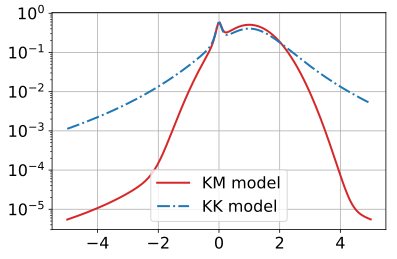

In [99]:
v_list = np.linspace(-5,5,num=200)
plt.plot(v_list,fkM(v_list),color='tab:red',label='KM model')
plt.plot(v_list,fkK(v_list),'-.',color='tab:blue',label='KK model')
plt.legend()
# plt.ylim(1e-4,10)
plt.yscale('log')
plt.grid()
plt.show()

In [71]:
k_list = np.linspace(0.1,2.0,num=200)
a_list = np.linspace(0,a,num=11)
w_2KM_guess = 0.009
r_2KM_guess = -0.011
w_2KK_guess = 0.009
r_2KK_guess = -0.011

In [72]:
for a_each in tqdm(a_list,position=0,leave=True):
    u_f = a_each * v_s
    
    s2KM = op.root(lambda w:PDR_2KM(w,k_list[0]),[w_2KM_guess,r_2KM_guess])
    if s2KM.success==True:
        w_2KM_guess = s2KM.x[0]
        r_2KM_guess = s2KM.x[1]
        
    s2KK = op.root(lambda w:PDR_2KK(w,k_list[0]),[w_2KK_guess,r_2KK_guess])
    if s2KK.success==True:
        w_2KK_guess = s2KK.x[0]
        r_2KK_guess = s2KK.x[1]

100%|███████████████████████████████████████████████| 11/11 [00:00<00:00, 13.75it/s]


In [73]:
u_f = a*v_s

w_2KM_list = []
r_2KM_list = []
w_2KK_list = []
r_2KK_list = []

for k_each in tqdm(k_list,position=0,leave=True):
    s2KM = op.root(lambda w:PDR_2KM(w,k_each),[w_2KM_guess,r_2KM_guess])
    if s2KM.success==True:
        w_2KM_guess = s2KM.x[0]
        r_2KM_guess = s2KM.x[1]
        w_2KM_list.append(s2KM.x[0])
        r_2KM_list.append(s2KM.x[1])
    else:
        w_2KM_list.append(np.nan)
        r_2KM_list.append(np.nan)
        
    s2KK = op.root(lambda w:PDR_2KK(w,k_each),[w_2KK_guess,r_2KK_guess])
    if s2KK.success==True:
        w_2KK_guess = s2KK.x[0]
        r_2KK_guess = s2KK.x[1]
        w_2KK_list.append(s2KK.x[0])
        r_2KK_list.append(s2KK.x[1])
    else:
        w_2KK_list.append(np.nan)
        r_2KK_list.append(np.nan)

100%|█████████████████████████████████████████████| 200/200 [00:17<00:00, 11.17it/s]


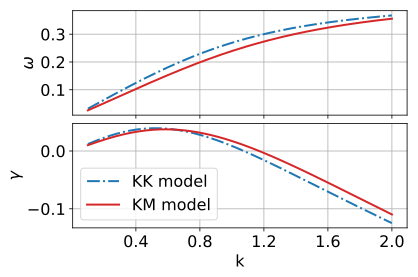

In [103]:
k_ticks = np.linspace(0,k_list[-1],num=6)
fig = plt.figure(figsize=(6,4))

ax1 = plt.subplot(211)
ax1.set_ylabel(r'$\omega$')
plt.xticks(k_ticks,[])
ax1.grid()

ax2 = plt.subplot(212)
plt.xticks(k_ticks)
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\gamma$')
ax2.grid()

ax1.plot(k_list,w_2KK_list,'-.',color='tab:blue',label='KK model')
ax1.plot(k_list,w_2KM_list,'-',color='tab:red',label='KM model')

ax2.plot(k_list,r_2KK_list,'-.',color='tab:blue',label='KK model')
ax2.plot(k_list,r_2KM_list,color='tab:red',label='KM model')
ax2.legend()
# ax2.axhline(0,color='black')

plt.subplots_adjust(hspace = 0.08,wspace=0.0)
# plt.savefig('./figs/revised/fig7.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

## unstable regime

## $n_s$ vs $a$

In [83]:
n_s = 0.01
v_s = 0.1
v_f = 1.0
a = 0
n_f,wp_s,wp_f,l_s,l_fM,l_fK,u_s,u_f,T_s,T_fM,T_fK,kappa_s = Set2KParas()

r2KM_max_mat = []
r2KK_max_mat = []

w_2KM_guess = 0.008
r_2KM_guess = -0.007
w_2KK_guess = 0.008
r_2KK_guess = -0.007

n_list = np.linspace(n_s,0.9,num=10)
a_list = np.linspace(0,10,num=10)

w_2KK_k0 = r_2KK_k0 = 0.0
w_2KK_a0 = r_2KK_a0 = 0.0
w_2KM_k0 = r_2KM_k0 = 0.0
w_2KM_a0 = r_2KM_a0 = 0.0

In [84]:
for n_each in tqdm(n_list,position=0,leave=True):
    n_s = n_each
    r2KM_max_list = []
    r2KK_max_list = []
    for a_each in a_list:
        a = a_each
        n_f,wp_s,wp_f,l_s,l_fM,l_fK,u_s,u_f,T_s,T_fM,T_fK,kappa_s = Set2KParas()
        r2KM_list=np.array([])
        r2KK_list=np.array([])
        for k_each in k_list:
            s2KM = op.root(lambda w:PDR_2KM(w,k_each),[w_2KM_guess,r_2KM_guess])
            if s2KM.success==True:
                w_2KM_guess = s2KM.x[0]
                r_2KM_guess = s2KM.x[1]
                r2KM_list = np.append(r2KM_list,s2KM.x[1])

            s2KK = op.root(lambda w:PDR_2KK(w,k_each),[w_2KK_guess,r_2KK_guess])
            if s2KK.success==True:
                w_2KK_guess = s2KK.x[0]
                r_2KK_guess = s2KK.x[1]
                r2KK_list = np.append(r2KK_list,s2KK.x[1])
                
            if k_each == k_list[0]:
                w_2KM_k0 = w_2KM_guess
                r_2KM_k0 = r_2KM_guess
                w_2KK_k0 = w_2KK_guess
                r_2KK_k0 = r_2KK_guess
                if a_each == a_list[0]:
                    w_2KM_a0 = w_2KM_k0
                    r_2KM_a0 = r_2KM_k0
                    w_2KK_a0 = w_2KK_k0
                    r_2KK_a0 = r_2KK_k0
        r2KM_max_list.append(np.amax(r2KM_list))
        r2KK_max_list.append(np.amax(r2KK_list))
        w_2KM_guess = w_2KM_k0
        r_2KM_guess = r_2KM_k0
        w_2KK_guess = w_2KK_k0
        r_2KK_guess = r_2KK_k0
    r2KM_max_mat.append(r2KM_max_list)
    r2KK_max_mat.append(r2KK_max_list)
    w_2KM_guess = w_2KM_a0
    r_2KM_guess = r_2KM_a0
    w_2KK_guess = w_2KK_a0
    r_2KK_guess = r_2KK_a0

100%|███████████████████████████████████████████████| 10/10 [08:48<00:00, 52.83s/it]


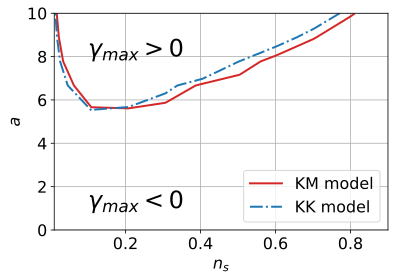

In [107]:
a_grid,n_s_grid=np.meshgrid(a_list,n_list)
c = plt.contour(n_s_grid,a_grid,r2KM_max_mat,levels=[-1,0,1],colors='tab:red')
d = plt.contour(n_s_grid,a_grid,r2KK_max_mat,levels=[-1,0,1],linestyles='-.',colors='tab:blue')
plt.plot([],[],'-',color='tab:red',label='KM model')
plt.plot([],[],'-.',color='tab:blue',label='KK model')
plt.text(0.1,8,r'$\gamma_{max}>0$',fontsize=24)
plt.text(0.1,1,r'$\gamma_{max}<0$',fontsize=24)
plt.legend(loc=4)
plt.xlabel('$n_s$')
plt.ylabel('$a$')
plt.grid()
plt.show()